# Non Transformer Models

## Imports

In [ ]:
# @title Install dependencies
!pip install pandas --quiet

!pip install torchtext --quiet


In [ ]:
# @title Importing Libraries
import os
import json
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from tqdm.notebook import tqdm
import nltk
from nltk.stem import WordNetLemmatizer

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader


from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

from imblearn.over_sampling import SMOTE

## title Converting JSON to CSV

In [ ]:
folder_path = "/content"
output_folder = os.path.join(folder_path, "csv")

if not os.path.exists(output_folder):
  os.makedirs(output_folder)

def json_to_csv(json_file, csv_file):
  with open (json_file, 'r') as f_in, open (csv_file, 'w', newline = '') as f_out:
    writer = csv.writer(f_out)
    writer.writerow(["text", "label", "label_text"])

    for line in f_in:
      data = json.loads(line)
      writer.writerow([data["text"], data["label"], data["label_text"]])

for file_name in ["train.jsonl", "dev.jsonl", "test.jsonl"]:
  json_file = os.path.join(folder_path, file_name)
  csv_file = os.path.join(output_folder, os.path.splitext(file_name)[0] + ".csv")
  json_to_csv(json_file, csv_file)

In [ ]:
def plot_confusion_matrix(y_true, y_pred,
                          class_dict=
                           {0: 'Very Negative', 1: 'Negative', 2: 'Neutral', 3: 'Positive', 4: 'Very Positive'}):

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(class_dict.values()), yticklabels=list(class_dict.values()))
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

## Loading Data

In [ ]:
train_path = "/content/csv/train.csv"
dev_path = "/content/csv/dev.csv"
test_path = "/content/csv/test.csv"


df_train = pd.read_csv(train_path)
df_dev = pd.read_csv(dev_path)
df_test = pd.read_csv(test_path)

df_dev.head(10)

,text,label,label_text
0,"in his first stab at the form , jacquot takes ...",2,neutral
1,one long string of cliches .,1,negative
2,if you 've ever entertained the notion of doin...,1,negative
3,k-19 exploits our substantial collective fear ...,0,very negative
4,it 's played in the most straight-faced fashio...,1,negative
5,"there is a fabric of complex ideas here , and ...",3,positive
6,it may seem long at 110 minutes if you 're not...,2,neutral
7,while the stoically delivered hokum of hart 's...,2,neutral
8,although laced with humor and a few fanciful t...,3,positive
9,it all feels like a monty python sketch gone h...,0,very negative


In [ ]:
x_train_text = df_train.text.values
y_train_label = df_train.label.values

x_dev_text = df_dev.text.values
y_dev_label = df_dev.label.values

x_test_text = df_test.text.values
y_test_label = df_test.label.values

index = 5

for i, (text, label) in enumerate(zip(x_train_text[:index], y_train_label[:index])):
  print(f"[{i}]. {label}: {text}")

[0]. 4: a stirring , funny and finally transporting re-imagining of beauty and the beast and 1930s horror films
[1]. 1: apparently reassembled from the cutting-room floor of any given daytime soap .
[2]. 1: they presume their audience wo n't sit still for a sociology lesson , however entertainingly presented , so they trot out the conventional science-fiction elements of bug-eyed monsters and futuristic women in skimpy clothes .
[3]. 2: the entire movie is filled with deja vu moments .
[4]. 3: this is a visually stunning rumination on love , memory , history and the war between art and commerce .


<ipython-input-7-1ca7a7a0b28b>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


<Axes: title={'center': 'Testing Set Score Count'}, xlabel='label', ylabel='count'>

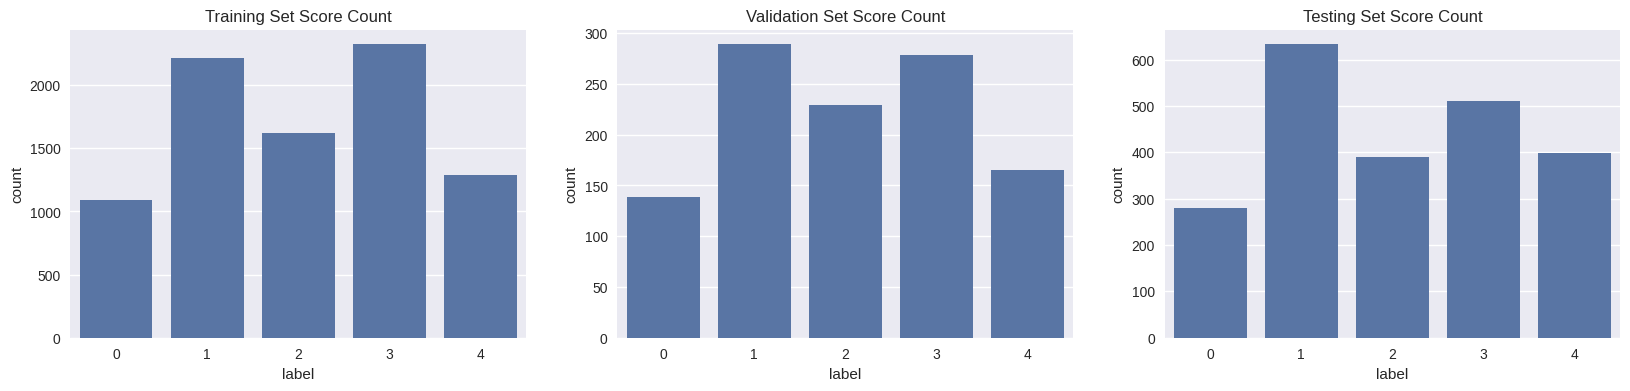

In [ ]:
plt.figure(figsize=(20, 4))
plt.style.use('seaborn')
plt.subplot(1, 3, 1)
plt.title("Training Set Score Count")
sns.countplot(df_train, x="label")

plt.subplot(1, 3, 2)
plt.title("Validation Set Score Count")
sns.countplot(df_dev, x="label")

plt.subplot(1, 3, 3)
plt.title("Testing Set Score Count")
sns.countplot(df_test, x="label")

## Preprocessing

In [ ]:
# Tokenizer function that also handles special characters and abbreviation
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('punkt') ## one time only process
nltk.download('wordnet')

def tokenize(text):

  tokens = nltk.word_tokenize(text)
  lemmatizer = WordNetLemmatizer()

  new_tokens = []

  bad_tokens = [',' , '.' , "this" , "at" , "is" , "'s" , "a" , "are" , "of" , "for" ,
                "at" , "as" , "with" , "from" , "the" , "and" , "to" , "it" , "that" ,
                "in" , "its" , "an" , "n't" , "be", 'on' , '...' , 'by',
                '--', 'than']

  # for token in tokens:
  #     if token not in bad_tokens:
  #         lemma = lemmatizer.lemmatize(token.lower())
  #         new_tokens.append(lemma)

  # Removing bad_tokens
  filtered_tokens = [token for token in tokens if token not in bad_tokens]

  new_tokens = [lemmatizer.lemmatize(token, pos='v') for token in filtered_tokens]

  return new_tokens

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
x_train_token = [tokenize(s) for s in tqdm(x_train_text)]
x_test_token = [tokenize(s) for s in tqdm(x_test_text)]
x_dev_token = [tokenize(s) for s in tqdm(x_test_text)]

  0%|          | 0/8544 [00:00<?, ?it/s]

  0%|          | 0/2210 [00:00<?, ?it/s]

  0%|          | 0/2210 [00:00<?, ?it/s]

In [ ]:
words = Counter()
for s in x_train_token:
  for w in s:
    words[w] += 1

for s in x_dev_token:
  for w in s:
    words[w] += 1

for s in x_test_token:
  for w in s:
    words[w] += 1

sorted_words = list(words.keys())
sorted_words.sort(key=lambda w: words[w], reverse=True)
print(f"Number of different Tokens in our Dataset: {len(sorted_words)}")
print(sorted_words[:10])

Number of different Tokens in our Dataset: 15675
['film', 'but', 'have', 'movie', 'you', 'do', 'not', 'make', 'be', 'like']


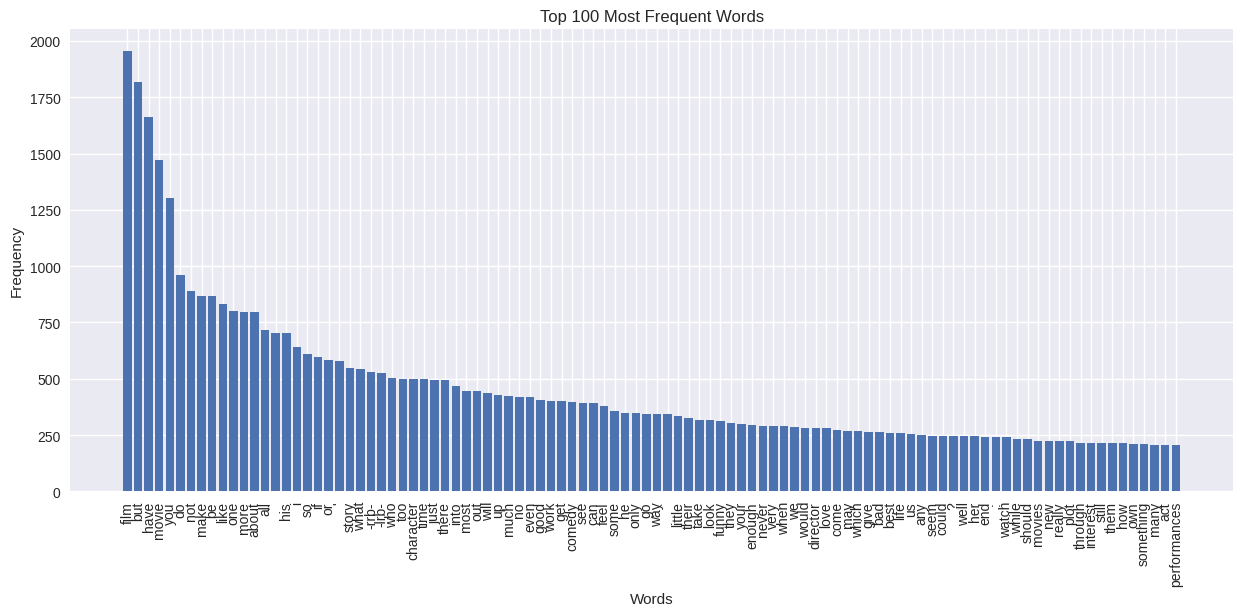

In [ ]:
top_words = sorted_words[:100]
top_counts = [words[w] for w in top_words]

plt.figure(figsize=(15, 6))
plt.bar(range(100), top_counts, tick_label=top_words)
plt.xticks(rotation=90)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 100 Most Frequent Words')
plt.show()

In [ ]:
x_train_tokenized = [' '.join(tokenize(text)) for text in tqdm(x_train_text)]
x_dev_tokenized = [' '.join(tokenize(text)) for text in tqdm(x_dev_text)]
x_test_tokenized = [' '.join(tokenize(text)) for text in tqdm(x_test_text)]

# Vectorization
vectorizer = CountVectorizer(binary=True)
vectorizer = TfidfVectorizer(binary=True, stop_words='english', ngram_range=(1, 2), max_features=5000)
x_train_cv = vectorizer.fit_transform(x_train_tokenized)
x_dev_cv = vectorizer.transform(x_dev_tokenized)
x_test_cv = vectorizer.transform(x_test_tokenized)

print('Before Vectorize: ', x_train_text[3])
print('After Vectorize: ')
print(x_train_cv[3])

  0%|          | 0/8544 [00:00<?, ?it/s]

  0%|          | 0/1101 [00:00<?, ?it/s]

  0%|          | 0/2210 [00:00<?, ?it/s]

Before Vectorize:  the entire movie is filled with deja vu moments .
After Vectorize: 
  (0, 1059)	0.43958866357758797
  (0, 1465)	0.42207145939013924
  (0, 2882)	0.2920877073239267
  (0, 4821)	0.43958866357758797
  (0, 1058)	0.43958866357758797
  (0, 2922)	0.1646966662282993
  (0, 1464)	0.3601400881518536


In [ ]:
print(x_train_tokenized[7])
print(x_train_token[7])
print(x_train_cv[7])

campanella get tone just right funny middle sad middle hopeful
['campanella', 'get', 'tone', 'just', 'right', 'funny', 'middle', 'sad', 'middle', 'hopeful']
  (0, 2143)	0.4271947133027353
  (0, 3751)	0.35974238357911537
  (0, 2813)	0.3565919132581833
  (0, 3662)	0.31397505894614325
  (0, 2389)	0.2415953437352695
  (0, 4548)	0.34809540138668243
  (0, 600)	0.46539975563485175
  (0, 1896)	0.2573253058203683


## SMOTE Oversampling

In [ ]:
# from collections import Counter

# counter_before = Counter(y_train_label)

# df_train = pd.read_csv(train_path)

# smote = SMOTE(random_state = 2024)
# x_train_resampled, y_train_resampled = smote.fit_resample(x_train_cv, y_train_label)


# counter_after = Counter(y_train_resampled)

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# # Before SMOTE
# ax1.bar(counter_before.keys(), counter_before.values())
# ax1.set_title('Class Distribution Before SMOTE')
# ax1.set_xlabel('Class')
# ax1.set_ylabel('Count')

# # After SMOTE
# ax2.bar(counter_after.keys(), counter_after.values())
# ax2.set_title('Class Distribution After SMOTE')
# ax2.set_xlabel('Class')
# ax2.set_ylabel('Count')

# plt.tight_layout()
# plt.show()


In [ ]:
# x_train_cv = x_train_resampled
# y_train_label2 = y_train_label
# y_train_label = y_train_resampled

## Machin Learning Models

### Logistic regression

In [ ]:
# @title Model Training
model = LogisticRegression(solver='saga', max_iter=1000, multi_class='auto')
model.fit(x_train_cv, y_train_label)

LogisticRegression(max_iter=1000, solver='saga')

Dev Set Evaluation:
              precision    recall  f1-score   support

           0       0.42      0.16      0.23       139
           1       0.40      0.55      0.46       289
           2       0.29      0.16      0.21       229
           3       0.36      0.54      0.43       279
           4       0.43      0.26      0.32       165

    accuracy                           0.37      1101
   macro avg       0.38      0.33      0.33      1101
weighted avg       0.37      0.37      0.35      1101



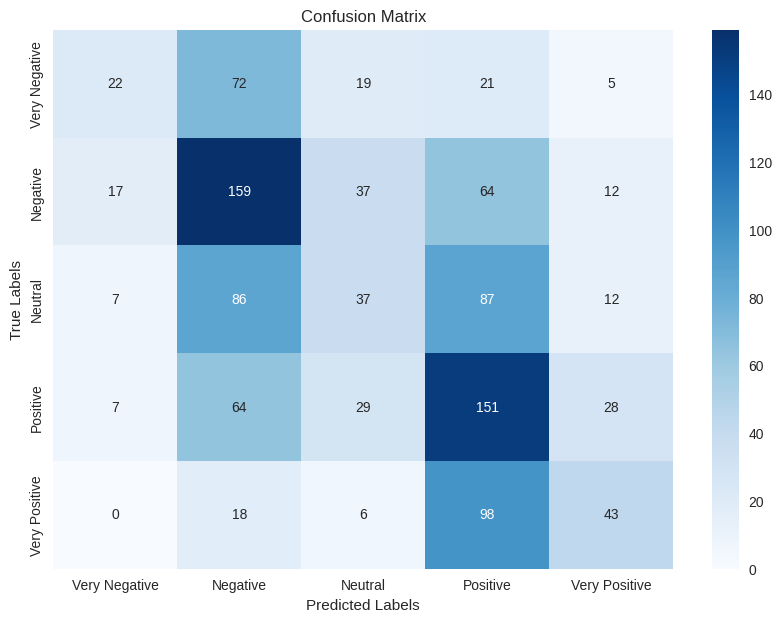

Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.42      0.15      0.22       279
           1       0.45      0.58      0.51       633
           2       0.24      0.15      0.19       389
           3       0.36      0.62      0.45       510
           4       0.59      0.27      0.37       399

    accuracy                           0.40      2210
   macro avg       0.41      0.35      0.35      2210
weighted avg       0.41      0.40      0.38      2210



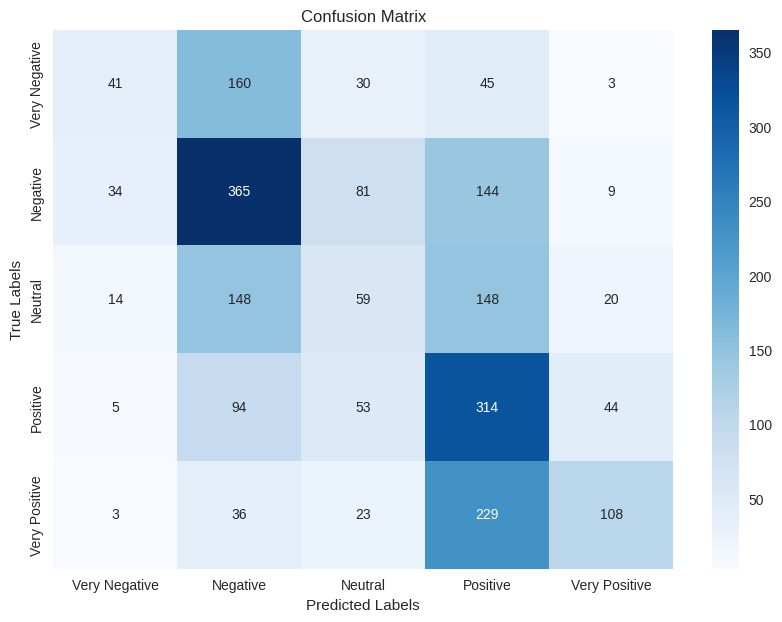

In [ ]:
# Evaluate on dev set
y_dev_pred = model.predict(x_dev_cv)
print("Dev Set Evaluation:")
print(classification_report(y_dev_label, y_dev_pred))
plot_confusion_matrix(y_dev_label, y_dev_pred)

# Evaluate on test set
y_test_pred = model.predict(x_test_cv)
print("Test Set Evaluation:")
print(classification_report(y_test_label, y_test_pred))
plot_confusion_matrix(y_test_label, y_test_pred)

### Logistic Regression with liblinear

In [ ]:
logistic_model = LogisticRegression(solver='liblinear', max_iter=1000, multi_class='auto')
logistic_model.fit(x_train_cv, y_train_label)

LogisticRegression(max_iter=1000, solver='liblinear')

Logistic Regression (liblinear) - Dev Set Evaluation:
              precision    recall  f1-score   support

           0       0.41      0.14      0.21       139
           1       0.39      0.56      0.46       289
           2       0.28      0.13      0.17       229
           3       0.36      0.57      0.44       279
           4       0.42      0.23      0.30       165

    accuracy                           0.37      1101
   macro avg       0.37      0.33      0.32      1101
weighted avg       0.37      0.37      0.34      1101



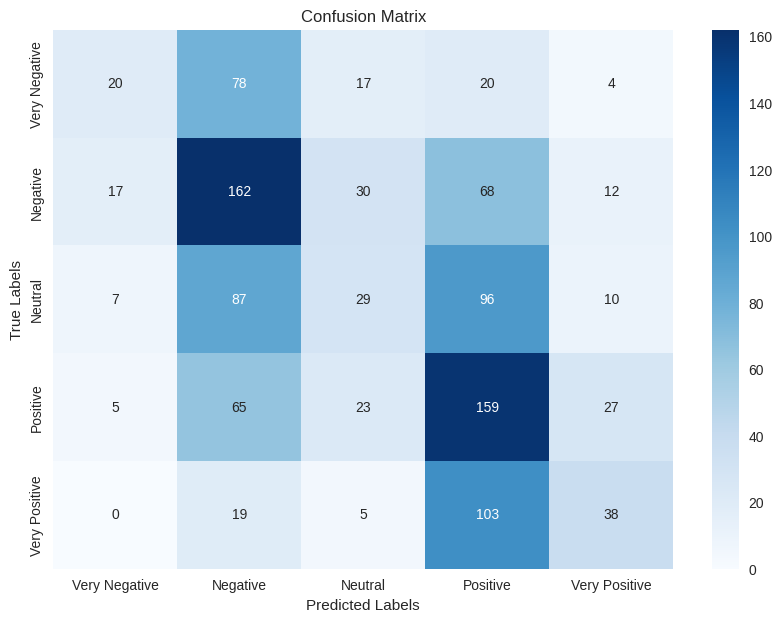

Logistic Regression (liblinear) - Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.44      0.12      0.19       279
           1       0.45      0.60      0.51       633
           2       0.24      0.13      0.17       389
           3       0.36      0.64      0.46       510
           4       0.59      0.25      0.35       399

    accuracy                           0.40      2210
   macro avg       0.42      0.35      0.33      2210
weighted avg       0.41      0.40      0.37      2210



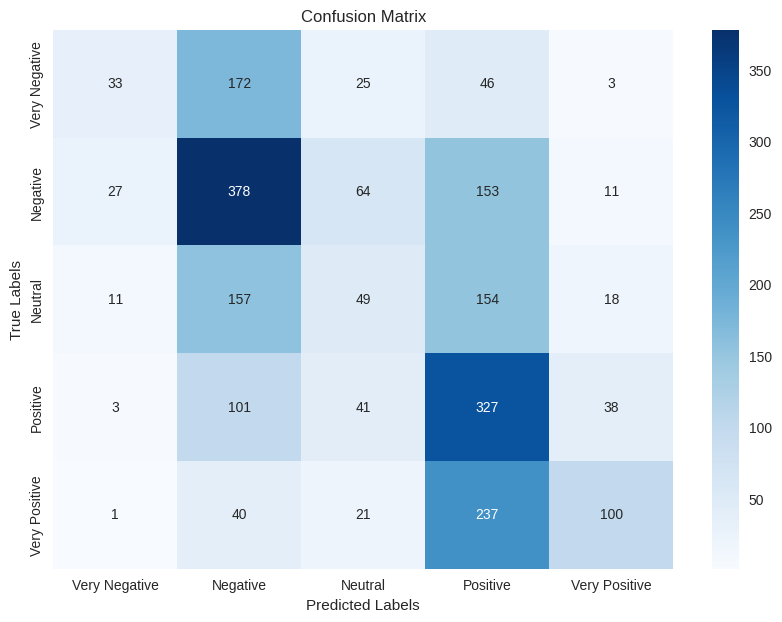

In [ ]:
# Evaluate on dev set
y_dev_pred = logistic_model.predict(x_dev_cv)
print("Logistic Regression (liblinear) - Dev Set Evaluation:")
print(classification_report(y_dev_label, y_dev_pred))
plot_confusion_matrix(y_dev_label, y_dev_pred)

# Evaluate on test set
y_test_pred = logistic_model.predict(x_test_cv)
print("Logistic Regression (liblinear) - Test Set Evaluation:")
print(classification_report(y_test_label, y_test_pred))
plot_confusion_matrix(y_test_label, y_test_pred)

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(x_train_cv, y_train_label)

RandomForestClassifier(random_state=42)

Random Forest Classifier - Dev Set Evaluation:
              precision    recall  f1-score   support

           0       0.32      0.15      0.21       139
           1       0.34      0.46      0.39       289
           2       0.31      0.21      0.25       229
           3       0.36      0.51      0.42       279
           4       0.37      0.21      0.26       165

    accuracy                           0.34      1101
   macro avg       0.34      0.31      0.31      1101
weighted avg       0.34      0.34      0.33      1101



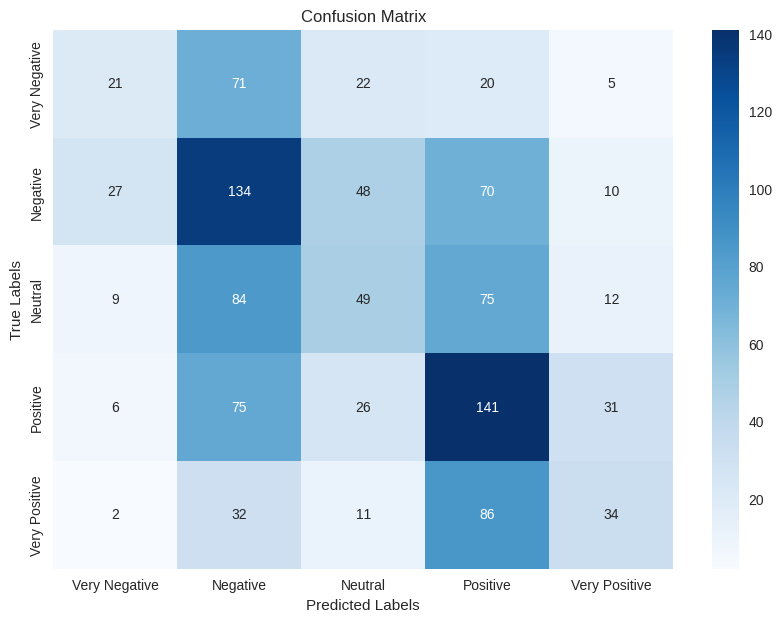

Random Forest Classifier - Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.30      0.11      0.16       279
           1       0.40      0.53      0.46       633
           2       0.27      0.24      0.25       389
           3       0.33      0.49      0.40       510
           4       0.49      0.22      0.30       399

    accuracy                           0.36      2210
   macro avg       0.36      0.32      0.31      2210
weighted avg       0.37      0.36      0.34      2210



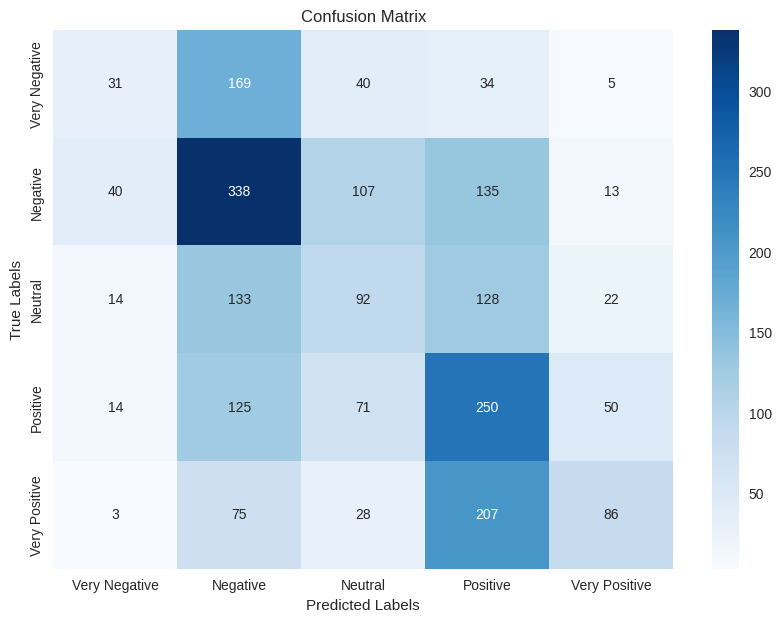

In [ ]:
# Evaluate on dev set
y_dev_pred = rf_model.predict(x_dev_cv)
print("Random Forest Classifier - Dev Set Evaluation:")
print(classification_report(y_dev_label, y_dev_pred))
plot_confusion_matrix(y_dev_label, y_dev_pred)

# Evaluate on test set
y_test_pred = rf_model.predict(x_test_cv)
print("Random Forest Classifier - Test Set Evaluation:")
print(classification_report(y_test_label, y_test_pred))
plot_confusion_matrix(y_test_label, y_test_pred)

### Support Vector Machine (SVM)

In [ ]:
svm_model = SVC(kernel="linear", max_iter=10000)
svm_model.fit(x_train_cv, y_train_label)

SVC(kernel='linear', max_iter=10000)

Dev Set Evaluation:
              precision    recall  f1-score   support

           0       0.41      0.21      0.28       139
           1       0.39      0.53      0.45       289
           2       0.31      0.19      0.23       229
           3       0.37      0.53      0.44       279
           4       0.46      0.27      0.34       165

    accuracy                           0.38      1101
   macro avg       0.39      0.35      0.35      1101
weighted avg       0.38      0.38      0.36      1101



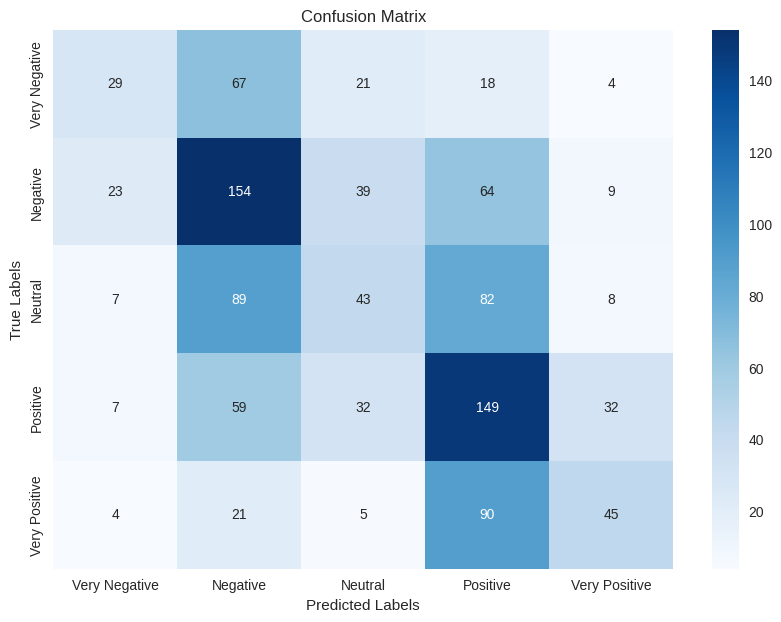

test Set Evaluation:
              precision    recall  f1-score   support

           0       0.36      0.17      0.23       279
           1       0.44      0.58      0.50       633
           2       0.22      0.15      0.17       389
           3       0.37      0.58      0.45       510
           4       0.62      0.29      0.39       399

    accuracy                           0.40      2210
   macro avg       0.40      0.35      0.35      2210
weighted avg       0.41      0.40      0.38      2210



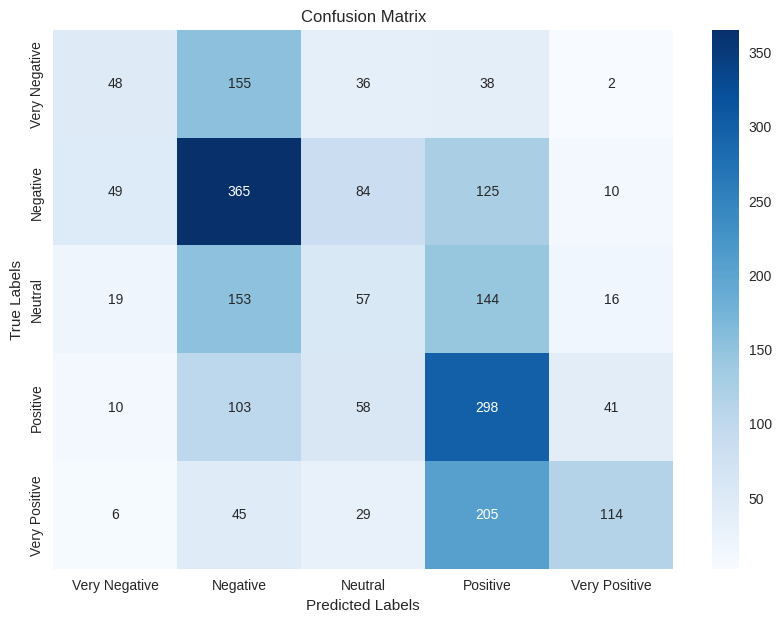

In [ ]:
y_dev_pred = svm_model.predict(x_dev_cv)
print("Dev Set Evaluation:")
print(classification_report(y_dev_label, y_dev_pred))

plot_confusion_matrix(y_dev_label, y_dev_pred)

y_test_pred = svm_model.predict(x_test_cv)
print("test Set Evaluation:")
print(classification_report(y_test_label, y_test_pred))

plot_confusion_matrix(y_test_label, y_test_pred)

## Modern Deep Learning Models

Epoch 1/100, Loss: 1.5756630897521973, Accuracy: 0.2646301498127341, Learning Rate: 0.1
Epoch 2/100, Loss: 1.647628903388977, Accuracy: 0.270248127340824, Learning Rate: 0.1
Epoch 3/100, Loss: 1.5465013980865479, Accuracy: 0.27879213483146065, Learning Rate: 0.1
Epoch 4/100, Loss: 1.5863398313522339, Accuracy: 0.289559925093633, Learning Rate: 0.1
Epoch 5/100, Loss: 1.5093873739242554, Accuracy: 0.30489232209737827, Learning Rate: 0.1
Epoch 6/100, Loss: 1.5520654916763306, Accuracy: 0.32572565543071164, Learning Rate: 0.1
Epoch 7/100, Loss: 1.6217666864395142, Accuracy: 0.32420411985018727, Learning Rate: 0.1
Epoch 8/100, Loss: 1.508515477180481, Accuracy: 0.35428370786516855, Learning Rate: 0.1
Epoch 9/100, Loss: 1.526269793510437, Accuracy: 0.38295880149812733, Learning Rate: 0.1
Epoch 10/100, Loss: 1.5504510402679443, Accuracy: 0.3916198501872659, Learning Rate: 0.1
Epoch 11/100, Loss: 1.40017831325531, Accuracy: 0.39957865168539325, Learning Rate: 0.1
Epoch 12/100, Loss: 1.37284517

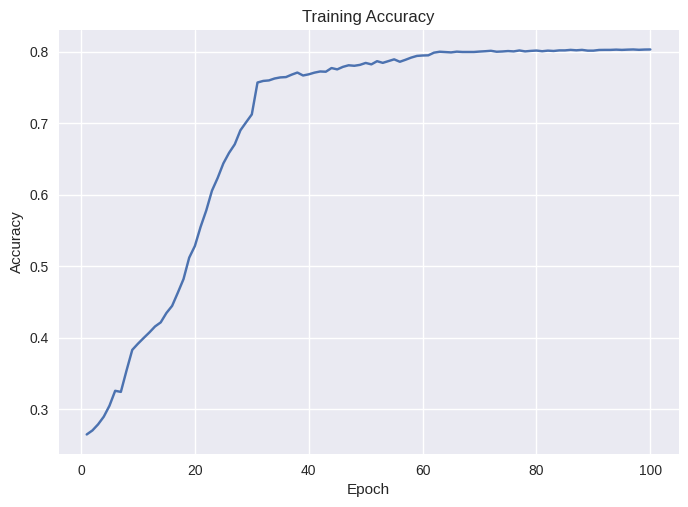

              precision    recall  f1-score   support

           0       0.36      0.26      0.30       279
           1       0.47      0.50      0.48       633
           2       0.25      0.23      0.24       389
           3       0.37      0.50      0.42       510
           4       0.53      0.39      0.45       399

    accuracy                           0.40      2210
   macro avg       0.40      0.37      0.38      2210
weighted avg       0.40      0.40      0.40      2210



In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Assume x_train_cv, y_train_label, x_test_cv, and y_test_label are predefined
input_size = x_train_cv.shape[1]
hidden_size = 100
num_classes = 5
learning_rate = 0.1
batch_size = 32
num_epochs = 100

# Convert data to tensors
x_train_tensor = torch.Tensor(x_train_cv.toarray())
y_train_tensor = torch.Tensor(y_train_label).long()

# Create dataset and dataloader
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize the model, loss function, optimizer, and learning rate scheduler
model = NeuralNetwork(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# Train the model
accuracy_values = []

for epoch in range(num_epochs):
    total_samples = 0
    correct_predictions = 0

    for inputs, labels in train_loader:
        inputs = inputs.float()
        labels = labels.squeeze().long()

        outputs = model(inputs)

        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    accuracy = correct_predictions / total_samples
    accuracy_values.append(accuracy)

    scheduler.step()  # Adjust the learning rate based on the scheduler

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, Accuracy: {accuracy}, Learning Rate: {scheduler.get_last_lr()[0]}")

# Plot the training accuracy
plt.plot(range(1, num_epochs + 1), accuracy_values)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.show()

# Test the model
x_test_tensor = torch.Tensor(x_test_cv.toarray())
y_test_tensor = torch.Tensor(y_test_label).long()

with torch.no_grad():
    x_test_tensor = x_test_tensor.float()
    outputs = model(x_test_tensor)
    _, predicted = torch.max(outputs.data, 1)

print(classification_report(y_test_label, predicted))


## Testing flair with different embedings

In [ ]:
!pip install flair --quiet

In [ ]:
import flair
from flair.data import Sentence
from flair.embeddings import ELMoEmbeddings, DocumentPoolEmbeddings
from flair.models import TextClassifier
from flair.trainers import ModelTrainer
from flair.datasets import CSVClassificationCorpus

In [ ]:
!pip install allennlp==0.9.0

In [ ]:
df_train[['text', 'label']].to_csv('/content/train_flair.csv', index=False, header=False)
df_dev[['text', 'label']].to_csv('/content/dev_flair.csv', index=False, header=False)
df_test[['text', 'label']].to_csv('/content/test_flair.csv', index=False, header=False)

columns = {0: 'text', 1: 'label'}

corpus = CSVClassificationCorpus(data_folder="/content", train_file='train_flair.csv',
                                 test_file='test_flair.csv', dev_file='dev_flair.csv',
                                 column_name_map=columns, delimiter=',',
                                 skip_header=False, label_type='label')

label_dict = corpus.make_label_dictionary(label_type='label')

embedding_types = [ELMoEmbeddings('original')]

document_embeddings = DocumentPoolEmbeddings(embedding_types)

classifier = TextClassifier(document_embeddings, label_dictionary=label_dict, label_type='label')

trainer = ModelTrainer(classifier, corpus)

trainer.train(base_path='flair_model', learning_rate=0.1,
              mini_batch_size=32, max_epochs=10)


In [ ]:
# Load the best model
classifier = TextClassifier.load('flair_model/final-model.pt')

# Evaluate on test set
result = classifier.evaluate(corpus.test)
print(result.detailed_results)

## Recurrent Neural Network (RNN)

In [ ]:
def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
          "if possible, in the menu under `Runtime` -> "
          "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device
# Set the device (check if gpu is available)
device = set_device()

GPU is enabled in this notebook.


In [ ]:
sorted_words[:10]

['film', 'but', 'have', 'movie', 'you', 'do', 'not', 'make', 'be', 'like']

In [ ]:
num_words_dict = 30000
# We reserve two numbers for special tokens.
most_used_words = sorted_words[:num_words_dict-2]

In [ ]:
# dictionary to go from words to idx
word_to_idx = {}
# dictionary to go from idx to words (just in case)
idx_to_word = {}


# We include the special tokens first
PAD_token = 0
UNK_token = 1

word_to_idx['PAD'] = PAD_token
word_to_idx['UNK'] = UNK_token

idx_to_word[PAD_token] = 'PAD'
idx_to_word[UNK_token] = 'UNK'

# We popullate our dictionaries with the most used words
for num,word in enumerate(most_used_words):
  word_to_idx[word] = num + 2
  idx_to_word[num+2] = word

In [ ]:
# A function to convert list of tokens to list of indexes
def tokens_to_idx(sentences_tokens,word_to_idx):
  sentences_idx = []
  for sent in sentences_tokens:
    sent_idx = []
    for word in sent:
      if word in word_to_idx:
        sent_idx.append(word_to_idx[word])
      else:
        sent_idx.append(word_to_idx['UNK'])
    sentences_idx.append(sent_idx)
  return sentences_idx
x_train_idx = tokens_to_idx(x_train_token,word_to_idx)
x_test_idx = tokens_to_idx(x_test_token,word_to_idx)
some_number = 7
print('Before converting: ', x_train_token[some_number])
print('After converting: ', x_train_idx[some_number])

Before converting:  ['campanella', 'get', 'tone', 'just', 'right', 'funny', 'middle', 'sad', 'middle', 'hopeful']
After converting:  [4429, 43, 375, 31, 208, 58, 761, 507, 761, 2000]


In [ ]:
movie_reviews_lens = np.asarray([len(sentence) for sentence in x_train_idx])
print('Max movie review length: ',movie_reviews_lens.max())
print('Mean movie review length: ',np.median(movie_reviews_lens))
print('99% percent under: ',np.quantile(movie_reviews_lens,0.99))

Max movie review length:  38
Mean movie review length:  11.0
99% percent under:  28.0


In [ ]:
 # We choose the max length
 max__length = 30

In [ ]:
# A function to make all the sequence have the same lenght
# Note that the output is a Numpy matrix
def padding(sentences, seq_len):
  features = np.zeros((len(sentences), seq_len),dtype=int)
  for ii, review in enumerate(sentences):
    len_review = len(review)
    if len_review != 0:
      if len_review <= seq_len:
        # If its shorter, we fill with zeros (the padding Token index)
        features[ii, -len(review):] = np.array(review)[:seq_len]
      if len_review > seq_len:
        # If its larger, we take the last 'seq_len' indexes
        features[ii, :] = np.array(review)[-seq_len:]
  return features

In [ ]:
# We convert our list of tokens into a numpy matrix
# where all instances have the same length
x_train_pad = padding(x_train_idx,max__length)
x_test_pad = padding(x_test_idx,max__length)

# We convert our target list a numpy matrix
y_train_np = np.asarray(y_train_label)
y_test_np = np.asarray(y_test_label)

In [ ]:
some_number = 2
print('Before padding: ', x_train_idx[some_number])
print('After padding: ', x_train_pad[some_number])

Before padding:  [59, 4424, 55, 129, 374, 422, 94, 5347, 1421, 716, 4425, 453, 19, 59, 3765, 35, 985, 5348, 581, 6748, 1613, 4426, 290, 5349, 1500]
After padding:  [   0    0    0    0    0   59 4424   55  129  374  422   94 5347 1421
  716 4425  453   19   59 3765   35  985 5348  581 6748 1613 4426  290
 5349 1500]


In [ ]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train_np))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test_np))

# Batch size (this is an important hyperparameter)
batch_size = 100

# dataloaders
# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size,drop_last = True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size,drop_last = True)

In [ ]:
# Obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.__next__()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([100, 30])
Sample input: 
 tensor([[    0,     0,     0,  ...,     0,    98,   390],
        [    0,     0,     0,  ...,   270,   163,   139],
        [    0,     0,     0,  ...,   127,  2135,  1579],
        ...,
        [    0,     0,     0,  ...,     6,   335,   944],
        [    0,     0,     0,  ...,   266, 11160,  5893],
        [    0,     0,     0,  ...,   486,   278,   447]])
Sample input: 
 tensor([3, 1, 3, 0, 2, 0, 0, 2, 2, 4, 4, 1, 1, 3, 3, 3, 3, 1, 2, 4, 2, 3, 3, 1,
        2, 2, 1, 1, 0, 0, 1, 3, 3, 4, 1, 1, 4, 3, 3, 1, 2, 3, 3, 1, 1, 2, 3, 3,
        2, 3, 1, 1, 2, 2, 0, 1, 2, 4, 4, 0, 3, 4, 2, 1, 1, 1, 0, 2, 1, 3, 1, 4,
        0, 3, 0, 2, 2, 2, 3, 3, 2, 1, 2, 3, 3, 2, 4, 1, 3, 2, 0, 1, 2, 0, 3, 3,
        0, 1, 1, 1])


In [ ]:
class SentimentRNN(nn.Module):
  def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.1):
    super(SentimentRNN,self).__init__()

    self.output_dim = output_dim
    self.hidden_dim = hidden_dim
    self.no_layers = no_layers
    self.vocab_size = vocab_size
    self.drop_prob = drop_prob

    # Embedding Layer
    self.embedding = nn.Embedding(vocab_size, embedding_dim)

    # LSTM Layers
    self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                        num_layers=no_layers, batch_first=True,
                        dropout=self.drop_prob)

    # Dropout layer
    self.dropout = nn.Dropout(drop_prob)

    # Linear and Sigmoid layer
    self.fc = nn.Linear(self.hidden_dim, output_dim)
    self.sig = nn.Sigmoid()

  def forward(self,x,hidden):
    batch_size = x.size(0)

    # Embedding out
    embeds = self.embedding(x)
    #Shape: [batch_size x max_length x embedding_dim]

    # LSTM out
    lstm_out, hidden = self.lstm(embeds, hidden)
    # Shape: [batch_size x max_length x hidden_dim]

    # Select the activation of the last Hidden Layer
    lstm_out = lstm_out[:,-1,:].contiguous()
    # Shape: [batch_size x hidden_dim]

    ## You can instead average the activations across all the times
    # lstm_out = torch.mean(lstm_out, 1).contiguous()

    # Dropout and Fully connected layer
    out = self.dropout(lstm_out)
    out = self.fc(out)

    # Sigmoid function
    sig_out = self.sig(out)

    # return last sigmoid output and hidden state
    return sig_out, hidden

  def init_hidden(self, batch_size):
    ''' Initializes hidden state '''
    # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
    # initialized to zero, for hidden state and cell state of LSTM
    h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
    c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
    hidden = (h0,c0)
    return hidden

In [ ]:
# Parameters of our network

# Size of our vocabulary
vocab_size = num_words_dict

# Embedding dimension
embedding_dim = 32

# Number of stacked LSTM layers
no_layers = 2

# Dimension of the hidden layer in LSTMs
hidden_dim = 64

# Dropout parameter for regularization
output_dim = 1

# Dropout parameter for regularization
drop_prob = 0.25

In [ ]:
# Let's define our model
model = SentimentRNN(no_layers, vocab_size, hidden_dim,
                     embedding_dim, drop_prob=drop_prob)
# Moving to gpu
model.to(device)
print(model)

SentimentRNN(
  (embedding): Embedding(30000, 32)
  (lstm): LSTM(32, 64, num_layers=2, batch_first=True, dropout=0.25)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [ ]:
# How many trainable parameters does our model have?
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print('Total Number of parameters: ',params)

Total Number of parameters:  1018433


In [ ]:
# loss and optimization functions
lr = 0.1

# Binary crossentropy is a good loss function for a binary classification problem
criterion = nn.CrossEntropyLoss()

# We choose an Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
  pred = torch.round(pred.squeeze())
  return torch.sum(pred == label.squeeze()).item()

In [ ]:
# Number of training Epochs
epochs = 900

# Maximum absolute value accepted for the gradeint
clip = 5

# Initial Loss value (assumed big)
valid_loss_min = np.inf

# Lists to follow the evolution of the loss and accuracy
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

# Train for a number of Epochs
for epoch in range(epochs):
  train_losses = []
  train_acc = 0.0
  model.train()

  for inputs, labels in train_loader:

    # Initialize hidden state
    h = model.init_hidden(batch_size)
    # Creating new variables for the hidden state
    h = tuple([each.data.to(device) for each in h])

    # Move batch inputs and labels to gpu
    inputs, labels = inputs.to(device), labels.to(device)

    # Set gradient to zero
    model.zero_grad()

    # Compute model output
    output,h = model(inputs,h)

    # Calculate the loss and perform backprop
    loss = criterion(output.squeeze(), labels.float())
    loss.backward()
    train_losses.append(loss.item())

    # calculating accuracy
    accuracy = acc(output,labels)
    train_acc += accuracy

    #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
    nn.utils.clip_grad_norm_(model.parameters(), clip)
    optimizer.step()


  # Evaluate on the validation set for this epoch
  val_losses = []
  val_acc = 0.0
  model.eval()
  for inputs, labels in valid_loader:

    # Initialize hidden state
    val_h = model.init_hidden(batch_size)
    val_h = tuple([each.data.to(device) for each in val_h])

    # Move batch inputs and labels to gpu
    inputs, labels = inputs.to(device), labels.to(device)

    # Compute model output
    output, val_h = model(inputs, val_h)

    # Compute Loss
    val_loss = criterion(output.squeeze(), labels.float())

    val_losses.append(val_loss.item())

    accuracy = acc(output,labels)
    val_acc += accuracy

  epoch_train_loss = np.mean(train_losses)
  epoch_val_loss = np.mean(val_losses)
  epoch_train_acc = train_acc/len(train_loader.dataset)
  epoch_val_acc = val_acc/len(valid_loader.dataset)
  epoch_tr_loss.append(epoch_train_loss)
  epoch_vl_loss.append(epoch_val_loss)
  epoch_tr_acc.append(epoch_train_acc)
  epoch_vl_acc.append(epoch_val_acc)
  print(f'Epoch {epoch+1}')
  print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
  print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
  if epoch_val_loss <= valid_loss_min:
    print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
    # torch.save(model.state_dict(), '../working/state_dict.pt')
    valid_loss_min = epoch_val_loss
  print(25*'==')

Epoch 1
train_loss : 947.4520651424632 val_loss : 946.3579323508523
train_accuracy : 12.909644194756552 val_accuracy : 12.53393665158371
Validation loss decreased (inf --> 946.357932).  Saving model ...
Epoch 2
train_loss : 947.2090274586398 val_loss : 944.5907343084162
train_accuracy : 12.827715355805244 val_accuracy : 12.53393665158371
Validation loss decreased (946.357932 --> 944.590734).  Saving model ...
Epoch 3
train_loss : 947.3841193704044 val_loss : 946.1136197176846
train_accuracy : 13.026685393258427 val_accuracy : 12.57918552036199
Epoch 4
train_loss : 946.8126170438878 val_loss : 945.3490212180398
train_accuracy : 13.588483146067414 val_accuracy : 12.53393665158371
Epoch 5
train_loss : 947.0305419921875 val_loss : 945.1674111106179
train_accuracy : 13.178838951310862 val_accuracy : 17.420814479638008
Epoch 6
train_loss : 946.1689998851103 val_loss : 945.4313520951705
train_accuracy : 22.343164794007492 val_accuracy : 12.57918552036199
Epoch 7
train_loss : 947.5879258099724

KeyboardInterrupt: 

In [ ]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()